This is a tutorial for basic use of abides_markets simulation.
It uses the simulator directly without the OpenAI Gym interface

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ipywidgets as widgets
from IPython.display import display


from abides_core import abides
from abides_core.utils import parse_logs_df, ns_date, str_to_ns, fmt_ts
from abides_markets.configs import rmsc01, rmsc02, rmsc03, rmsc05, rmsc04, rmsc06

In [4]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

from abides_core.utils import get_wake_time, str_to_ns
from abides_markets.agents import (
    ExchangeAgent,
    NoiseAgent,
    ValueAgent,
    AdaptiveMarketMakerAgent,
    MomentumAgent,
)
from abides_markets.models import OrderSizeModel
from abides_markets.oracles import SparseMeanRevertingOracle
from abides_markets.utils import generate_latency_model

## Set Parameters

In [5]:
int_slider = widgets.IntSlider(min=1, max=10, value=2, step=1, description="Market Making Agents")

int_slider2 = widgets.IntSlider(min=0, max=1000, value=102, step=1, description="Value Agents")
int_slider3 = widgets.IntSlider(min=0, max=200, value=12, step=1, description="Momentum Agents")
int_slider4 = widgets.IntSlider(min=0, max=10000, value=1000, step=1, description="Noise Agents")

display(int_slider)
display(int_slider2)
display(int_slider3)
display(int_slider4)

IntSlider(value=2, description='Market Making Agents', max=10, min=1)

IntSlider(value=102, description='Value Agents', max=1000)

IntSlider(value=12, description='Momentum Agents', max=200)

IntSlider(value=1000, description='Noise Agents', max=10000)

In [6]:
def build_config(
    seed=int(datetime.now().timestamp() * 1_000_000) % (2 ** 32 - 1),
    date="20210205",
    end_time="10:00:00",
    stdout_log_level="INFO",
    ticker="ABM",
    starting_cash=10_000_000,  # Cash in this simulator is always in CENTS.
    log_orders=True,  # if True log everything
    # 1) Exchange Agent
    book_logging=True,
    book_log_depth=10,
    stream_history_length=500,
    exchange_log_orders=None,
    # 2) Noise Agent
    num_noise_agents=int_slider4.value,
    # 3) Value Agents
    num_value_agents=int_slider2.value,
    r_bar=100_000,  # true mean fundamental value
    kappa=1.67e-15,  # Value Agents appraisal of mean-reversion
    lambda_a=5.7e-12,  # ValueAgent arrival rate
    # oracle
    kappa_oracle=1.67e-16,  # Mean-reversion of fundamental time series.
    sigma_s=0,
    fund_vol=5e-10,  # Volatility of fundamental time series.
    megashock_lambda_a=2.77778e-18,
    megashock_mean=1000,
    megashock_var=50_000,
    # 4) Market Maker Agents
    # each elem of mm_params is tuple (window_size, pov, num_ticks, wake_up_freq, min_order_size)
    mm_window_size="adaptive",
    mm_pov=0.025,
    mm_num_ticks=10,
    mm_wake_up_freq="60S",
    mm_min_order_size=1,
    mm_skew_beta=0,
    mm_price_skew=4,
    mm_level_spacing=5,
    mm_spread_alpha=0.75,
    mm_backstop_quantity=0,
    mm_cancel_limit_delay=50,  # 50 nanoseconds
    # 5) Momentum Agents
    num_momentum_agents=int_slider3.value,
):
    """
    create the background configuration for rmsc04
    These are all the non-learning agent that will run in the simulation
    :param seed: seed of the experiment
    :type seed: int
    :param log_orders: debug mode to print more
    :return: all agents of the config
    :rtype: list
    """

    # fix seed
    np.random.seed(seed)

    def path_wrapper(pomegranate_model_json):
        """
        temporary solution to manage calls from abides-gym or from the rest of the code base
        TODO:find more general solution
        :return:
        :rtype:
        """
        # get the  path of the file
        path = os.getcwd()
        if path.split("/")[-1] == "abides_gym":
            return "../" + pomegranate_model_json
        else:
            return pomegranate_model_json

    mm_wake_up_freq = str_to_ns(mm_wake_up_freq)

    # order size model
    ORDER_SIZE_MODEL = OrderSizeModel()  # Order size model
    # market marker derived parameters
    #MM_PARAMS = [
    #    (mm_window_size, mm_pov, mm_num_ticks, mm_wake_up_freq, mm_min_order_size),
    #    (mm_window_size, mm_pov, mm_num_ticks, mm_wake_up_freq, mm_min_order_size),
    #]
    MM_PARAMS = []
    for _ in range(int_slider.value):
        MM_PARAMS.append((mm_window_size, mm_pov, mm_num_ticks, mm_wake_up_freq, mm_min_order_size))
        
    NUM_MM = len(MM_PARAMS)
    # noise derived parameters
    SIGMA_N = r_bar / 100  # observation noise variance

    # date&time
    DATE = int(pd.to_datetime(date).to_datetime64())
    MKT_OPEN = DATE + str_to_ns("09:30:00")
    MKT_CLOSE = DATE + str_to_ns(end_time)
    # These times needed for distribution of arrival times of Noise Agents
    NOISE_MKT_OPEN = MKT_OPEN - str_to_ns("00:30:00")
    NOISE_MKT_CLOSE = DATE + str_to_ns("16:00:00")

    # oracle
    symbols = {
        ticker: {
            "r_bar": r_bar,
            "kappa": kappa_oracle,
            "sigma_s": sigma_s,
            "fund_vol": fund_vol,
            "megashock_lambda_a": megashock_lambda_a,
            "megashock_mean": megashock_mean,
            "megashock_var": megashock_var,
            "random_state": np.random.RandomState(
                seed=np.random.randint(low=0, high=2 ** 32)
            ),
        }
    }

    oracle = SparseMeanRevertingOracle(MKT_OPEN, NOISE_MKT_CLOSE, symbols)

    # Agent configuration
    agent_count, agents, agent_types = 0, [], []

    agents.extend(
        [
            ExchangeAgent(
                id=0,
                name="EXCHANGE_AGENT",
                type="ExchangeAgent",
                mkt_open=MKT_OPEN,
                mkt_close=MKT_CLOSE,
                symbols=[ticker],
                book_logging=book_logging,
                book_log_depth=book_log_depth,
                log_orders=exchange_log_orders,
                pipeline_delay=0,
                computation_delay=0,
                stream_history=stream_history_length,
                random_state=np.random.RandomState(
                    seed=np.random.randint(low=0, high=2 ** 32, dtype="uint64")
                ),
            )
        ]
    )
    agent_types.extend("ExchangeAgent")
    agent_count += 1

    agents.extend(
        [
            NoiseAgent(
                id=j,
                name="NoiseAgent {}".format(j),
                type="NoiseAgent",
                symbol=ticker,
                starting_cash=starting_cash,
                wakeup_time=get_wake_time(NOISE_MKT_OPEN, NOISE_MKT_CLOSE),
                log_orders=log_orders,
                order_size_model=ORDER_SIZE_MODEL,
                random_state=np.random.RandomState(
                    seed=np.random.randint(low=0, high=2 ** 32, dtype="uint64")
                ),
            )
            for j in range(agent_count, agent_count + num_noise_agents)
        ]
    )
    agent_count += num_noise_agents
    agent_types.extend(["NoiseAgent"])

    agents.extend(
        [
            ValueAgent(
                id=j,
                name="Value Agent {}".format(j),
                type="ValueAgent",
                symbol=ticker,
                starting_cash=starting_cash,
                sigma_n=SIGMA_N,
                r_bar=r_bar,
                kappa=kappa,
                lambda_a=lambda_a,
                log_orders=log_orders,
                order_size_model=ORDER_SIZE_MODEL,
                random_state=np.random.RandomState(
                    seed=np.random.randint(low=0, high=2 ** 32, dtype="uint64")
                ),
            )
            for j in range(agent_count, agent_count + num_value_agents)
        ]
    )
    agent_count += num_value_agents
    agent_types.extend(["ValueAgent"])

    agents.extend(
        [
            AdaptiveMarketMakerAgent(
                id=j,
                name="ADAPTIVE_POV_MARKET_MAKER_AGENT_{}".format(j),
                type="AdaptivePOVMarketMakerAgent",
                symbol=ticker,
                starting_cash=starting_cash,
                pov=MM_PARAMS[idx][1],
                min_order_size=MM_PARAMS[idx][4],
                window_size=MM_PARAMS[idx][0],
                num_ticks=MM_PARAMS[idx][2],
                wake_up_freq=MM_PARAMS[idx][3],
                poisson_arrival=True,
                cancel_limit_delay=mm_cancel_limit_delay,
                skew_beta=mm_skew_beta,
                price_skew_param=mm_price_skew,
                level_spacing=mm_level_spacing,
                spread_alpha=mm_spread_alpha,
                backstop_quantity=mm_backstop_quantity,
                log_orders=log_orders,
                random_state=np.random.RandomState(
                    seed=np.random.randint(low=0, high=2 ** 32, dtype="uint64")
                ),
            )
            for idx, j in enumerate(range(agent_count, agent_count + NUM_MM))
        ]
    )
    agent_count += NUM_MM
    agent_types.extend("POVMarketMakerAgent")

    agents.extend(
        [
            MomentumAgent(
                id=j,
                name="MOMENTUM_AGENT_{}".format(j),
                type="MomentumAgent",
                symbol=ticker,
                starting_cash=starting_cash,
                min_size=1,
                max_size=10,
                wake_up_freq=str_to_ns("37s"),
                poisson_arrival=True,
                log_orders=log_orders,
                order_size_model=ORDER_SIZE_MODEL,
                random_state=np.random.RandomState(
                    seed=np.random.randint(low=0, high=2 ** 32, dtype="uint64")
                ),
            )
            for j in range(agent_count, agent_count + num_momentum_agents)
        ]
    )
    agent_count += num_momentum_agents
    agent_types.extend("MomentumAgent")

    # extract kernel seed here to reproduce the state of random generator in old version
    random_state_kernel = np.random.RandomState(
        seed=np.random.randint(low=0, high=2 ** 32, dtype="uint64")
    )
    # LATENCY
    latency_model = generate_latency_model(agent_count)

    default_computation_delay = 50  # 50 nanoseconds

    ##kernel args
    kernelStartTime = DATE
    kernelStopTime = MKT_CLOSE + str_to_ns("1s")

    return {
        "seed": seed,
        "start_time": kernelStartTime,
        "stop_time": kernelStopTime,
        "agents": agents,
        "agent_latency_model": latency_model,
        "default_computation_delay": default_computation_delay,
        "custom_properties": {"oracle": oracle},
        "random_state_kernel": random_state_kernel,
        "stdout_log_level": stdout_log_level,
        }


## Build runnable configuration

Here we are generating/building a config from the config file rmsc04. 
The config object is a dictionnary containing key elements like, start time, end time, agents to be used, latency and computation delay models.

In [13]:
int_slider = widgets.IntSlider(min=1, max=10, value=2, step=1, description="Market Making Agents")

int_slider2 = widgets.IntSlider(min=0, max=1000, value=102, step=1, description="Value Agents")
int_slider3 = widgets.IntSlider(min=0, max=200, value=12, step=1, description="Momentum Agents")
int_slider4 = widgets.IntSlider(min=0, max=10000, value=1000, step=1, description="Noise Agents")

int_slider

IntSlider(value=2, description='Market Making Agents', max=10, min=1)

In [14]:
int_slider2

IntSlider(value=102, description='Value Agents', max=1000)

In [15]:
int_slider3

IntSlider(value=12, description='Momentum Agents', max=200)

In [16]:
int_slider4

IntSlider(value=1000, description='Noise Agents', max=10000)

If cells above are not displayed as widget we can also set the parameteres via code

In [24]:
int_slider.value = 2
int_slider2.value = 102
int_slider3.value = 12
int_slider4.value = 1000

In [25]:
config = build_config()
plot_name = "base_config"

In [26]:
config.keys()

dict_keys(['seed', 'start_time', 'stop_time', 'agents', 'agent_latency_model', 'default_computation_delay', 'custom_properties', 'random_state_kernel', 'stdout_log_level'])

## Running simulation

Once the config is ready it can be run using the abides runner function.
It instanciates a simulation kernel, runs the configuration and returns an end_state that mostly contains pointers to the different agent objects.
The agents are in their final state, their internal variables can be accessed to extract informations of interests like logs.

In [27]:
end_state = abides.run( config )

[655183] INFO abides Simulation Start Time: 2023-02-07 03:10:52.785781
[655183] INFO abides_core.kernel --- Simulation time: 2021-02-05 00:00:00, messages processed: 0, wallclock elapsed: 0.00s ---
[655183] INFO abides_core.kernel Event Queue elapsed: 0:00:02.330367, messages: 51,734, messages per second: 22199.9
[655183] INFO abides_core.kernel Mean ending value by agent type:
[655183] INFO abides_core.kernel NoiseAgent: -69
[655183] INFO abides_core.kernel ValueAgent: 665
[655183] INFO abides_core.kernel AdaptivePOVMarketMakerAgent: -10096
[655183] INFO abides_core.kernel MomentumAgent: 1755
[655183] INFO abides_core.kernel Simulation ending!
[655183] INFO abides Simulation End Time: 2023-02-07 03:10:55.915530
[655183] INFO abides Time taken to run simulation: 0:00:03.129749


## Retrieving results from end_state

By convention in abides_markets configuration the first agent is the exchange agent. 
It contains an order_book. By default it logs its history.

In [28]:
order_book = end_state["agents"][0].order_books["ABM"]

### Order book history L1

L1 data snapshots for every tick can be extracted
( best bid and ask price and quantity )

In [29]:
L1 = order_book.get_L1_snapshots()

Here we plot the time series of the best bid and best ask price thoughout the simulation

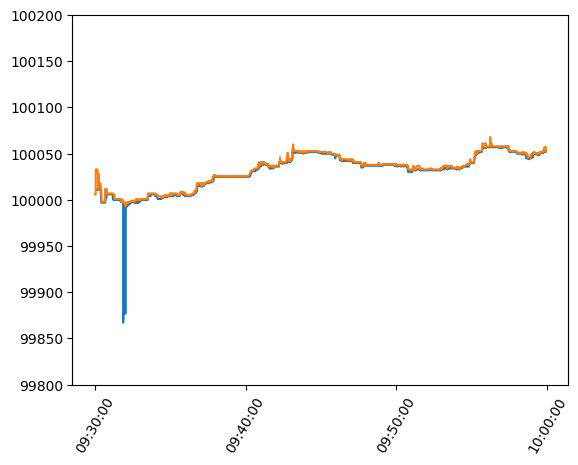

In [30]:
best_bids = pd.DataFrame(L1["best_bids"],columns=["time","price","qty"])
best_asks = pd.DataFrame(L1["best_asks"],columns=["time","price","qty"])

## All times are in ns from 1970, remove the date component to put them in ns from midnight
best_bids["time"] = best_bids["time"].apply( lambda x: x - ns_date(x) )
best_asks["time"] = best_asks["time"].apply( lambda x: x - ns_date(x) )

plt.plot(best_bids.time,best_bids.price)
plt.plot(best_asks.time,best_asks.price)

band = 200
plt.ylim(100_000-band,100_000+band)

time_mesh = np.arange(
    str_to_ns("09:30:00"),
    str_to_ns("10:10:00"),
    1e9*60*10
)
_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )

plt.savefig("plots/" + plot_name + "L1.pdf")

### Order book history L2

L2 data snapshots for every tick can be extracted
( bids and asks price and quantity for every orderbook level. Here max depth logged is a parameter of the simulation and max number of levels we want to retrieve from the orderbook after the simulation is a parameter too)

In [31]:
L2 = order_book.get_L2_snapshots(nlevels=10)

As an illustration we plot the time series of the fifth best bid price and fifth best ask price throughout the simulation

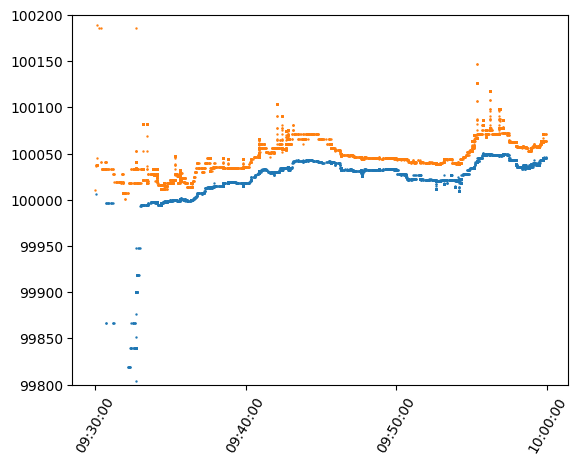

In [32]:
## plotting fifth best bid and fifth best ask
times = [ t - ns_date(t) for t in L2["times"] ]
plt.scatter( times, L2["bids"][:,5,0], s=.5 )
plt.scatter( times, L2["asks"][:,5,0], s=.5 )

band = 200
plt.ylim(100_000-band,100_000+band)

_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )
plt.savefig("plots/"+ plot_name+ "L2.pdf")


### Looking at agents logs

All agents can be inspected to retrieve desired information. 
The utility parse_logs_df for instance provides a quick way to retrieve and aggregate the log variables of each agent in a single dataframe

In [33]:
logs_df = parse_logs_df( end_state )

#### Histogram of order submission times for noise agents

As an illustration we retrieve the submission times of all the orders sent by noise agent and display the histogram of all these times

(array([  0.,   0.,   0.,   0.,   0., 114.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

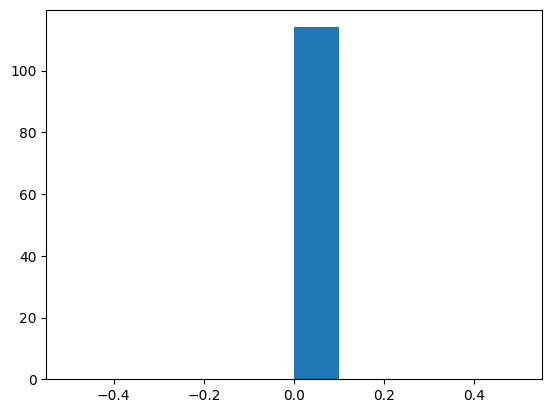

In [34]:
plt.hist( logs_df[ (logs_df.agent_type == "NoiseAgent") & (logs_df.EventType=="ORDER_SUBMITTED") ].EventTime.apply(lambda x: x - ns_date(x) )  )

#_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )





We proceed the same way for value agents as well

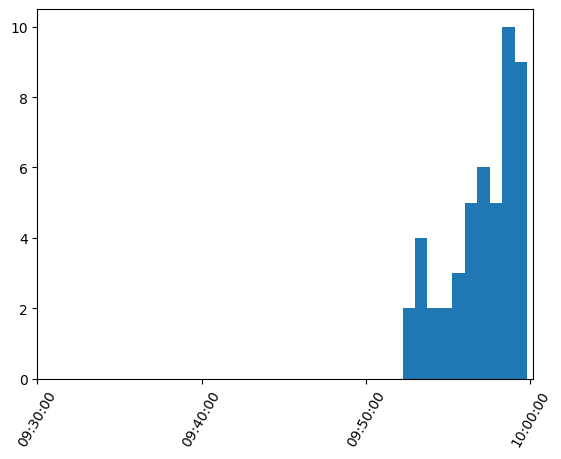

In [35]:
plt.hist( logs_df[ (logs_df.agent_type == "MomentumAgent") & (logs_df.EventType=="ORDER_SUBMITTED") ].EventTime.apply(lambda x: x - ns_date(x) )  )

_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )